In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm

from IPython.display import HTML

from sightings import (
    e_step,
    generate_observations,
    m_step,
    ray_likelihood,
    rotate,
    visualize_assignments,
    visualize_observations,
    visualize_weights,
)

# Data generation

Here we can see that we can generate data of different dimensions, and we know the true underlying body and observer locations.

In [2]:
true_bodies, observers, observer_ids, true_labels, observations = generate_observations(
    n_bodies=3,
    n_observers=10,
    xy_bounds=(0, 10),
    std=np.deg2rad(5),
    sight_bounds=(0, 100),
)

# Package these together, they are frequently all needed
obs_kwargs = {
    "observers": observers,
    "observer_ids": observer_ids,
    "observations": observations,
}

Text(0.5, 1.0, 'Observations with the true source labels')

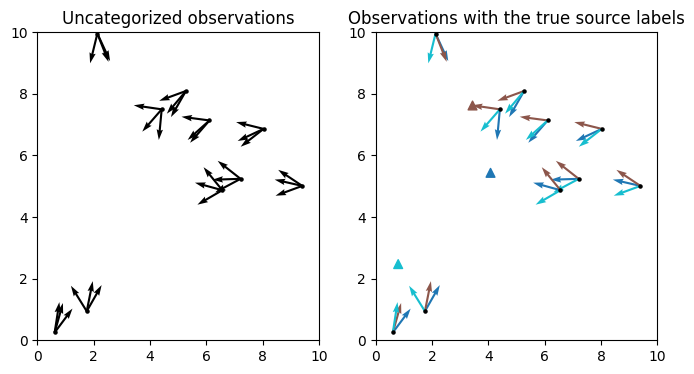

In [3]:
figure, axes = plt.subplots(1, 2, figsize=(8, 4))

visualize_observations(axes[0], **obs_kwargs)
visualize_observations(axes[1], bodies=true_bodies, labels=true_labels, **obs_kwargs)

for axis in axes:
    axis.set_xlim(0, 10)
    axis.set_ylim(0, 10)

axes[0].set_title("Uncategorized observations")
axes[1].set_title("Observations with the true source labels")

# Von Mises error

TODO: Explain and add some wikipedia links

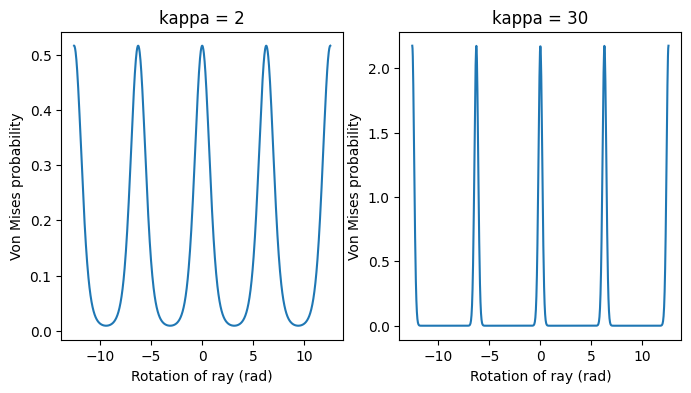

In [4]:
# Plot the Von Mises error around several rotations to see if it behaves
# well in all orientations
figure, axes = plt.subplots(1, 2, figsize=(8, 4))

x = np.linspace(-4 * np.pi, 4 * np.pi, 1000)
for axis, kappa in zip(axes, [2, 30]):
    y = [
        ray_likelihood(
            observer=np.array([0, 0]),
            body=np.array([10, 0]),
            ray=rotate(vector=np.array([1, 0]), angle=angle),
            kappa=kappa,
        )
        for angle in x
    ]
    axis.plot(x, y)
    axis.set_ylabel("Von Mises probability")
    axis.set_xlabel("Rotation of ray (rad)")
    axis.set_title(f"kappa = {kappa}")

# Expectation (E-Step)

In this case, the parameters are $\phi_j$ and $\mu_j$.

In [5]:
# Number of sources
K = 3

# Start off with the assumed source weights uniform
param_psi = np.ones(K) / K

# Choose random locations as the assumed starting body locations
param_mu = np.random.uniform(0, 10, size=(3, 2))

# Approximately equal
kappa = 1 / np.deg2rad(5)**2

In [6]:
e_weights = e_step(K, param_mu, param_psi, kappa, **obs_kwargs)
print("Do the per-source weights sum to 1 for each observation?")
print(np.sum(e_weights, axis=1).reshape(-1, 1)[:5], "...")

Do the per-source weights sum to 1 for each observation?
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]] ...


### Visualize
Do individual weightings make sense? Compare the weight values (line thickness) to the nearness of the **prototype** bodies. These are first guess for the body locations, **not** the true body locations.

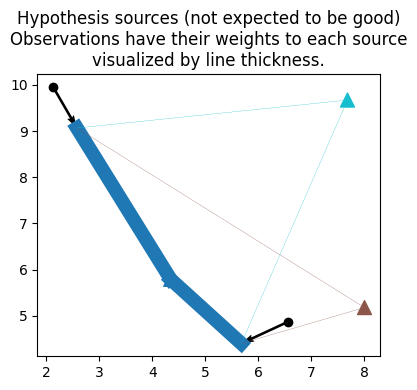

In [7]:
figure, axis = plt.subplots(1, 1, figsize=(4, 4))
for i in np.random.choice(range(len(observations)), size=2, replace=False):
    visualize_weights(
        axis,
        observers[observer_ids[i]],
        observations[i],
        e_weights[i],
        param_mu,
    )
visualize_observations(axis, bodies=param_mu, bodysize=100)

axis.set_title(
    "Hypothesis sources (not expected to be good)\n"
    "Observations have their weights to each source\n"
    "visualized by line thickness."
)
figure.tight_layout()

What if we visualize the points most highly weights for each body as being assigned to that body?

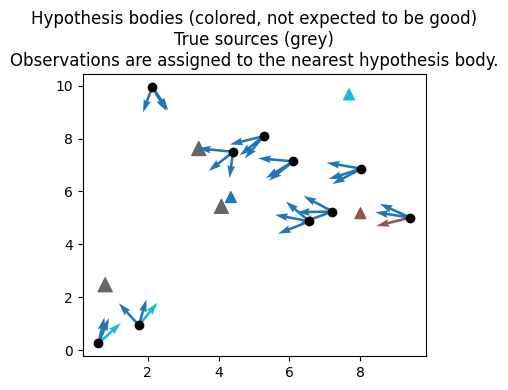

In [8]:
figure, axis = plt.subplots(1, 1, figsize=(4, 4))
visualize_observations(axis, bodies=true_bodies, cmap_name="grey", bodysize=100)
visualize_observations(axis, bodies=param_mu, bodysize=60)
visualize_assignments(
    axis,
    e_weights,
    **obs_kwargs,
)

axis.set_title(
    "Hypothesis bodies (colored, not expected to be good)\n"
    "True sources (grey)\n"
    "Observations are assigned to the nearest hypothesis body."
)
figure.tight_layout()

# Maximization (M-Step)

In [9]:
# Take a step to get revised parameter values
param_mu, param_psi, _ = m_step(e_weights, param_mu, param_psi, kappa, **obs_kwargs)

### Visualize
Are the new parameters (body estimations) an improvement?

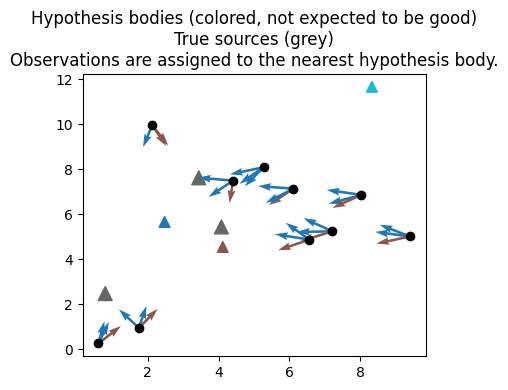

In [10]:
figure, axis = plt.subplots(1, 1, figsize=(4, 4))
visualize_observations(axis, bodies=true_bodies, cmap_name="grey", bodysize=100)
visualize_observations(axis, bodies=param_mu, bodysize=60)
visualize_assignments(
    axis,
    e_step(K, param_mu, param_psi, kappa, **obs_kwargs),
    **obs_kwargs,
)

axis.set_title(
    "Hypothesis bodies (colored, not expected to be good)\n"
    "True sources (grey)\n"
    "Observations are assigned to the nearest hypothesis body."
)
figure.tight_layout()

# Loop!

Now let's do the whole process in a loop, track the history, and animate the change over time!

TODO:

1. Add the ideas of sight limits and segment likelihood
2. Add the idea of depressing same-observation matches
3. Add in false positives and false negatives

In [11]:
######## Setup ########

# Number of sources
K = 5

# Number of iterations
iterations = 100

# Start off with the assumed source weights uniform
param_psi = np.ones(K) / K

# Choose random locations as the assumed starting body locations
param_mu = np.random.uniform(0, 10, size=(K, 2))

# Approximately equal
kappa = 1 / np.deg2rad(5)**2

In [12]:
# Loop and track history
history = [
    (param_mu.copy(), param_psi.copy(), np.nan)
]
for i in tqdm(range(iterations)):
    e_weights = e_step(K, param_mu, param_psi, kappa, **obs_kwargs)
    param_mu, param_psi, cost = m_step(e_weights, param_mu, param_psi, kappa, **obs_kwargs)
    history.append((param_mu.copy(), param_psi.copy(), cost))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.82it/s]


### Visualize!
Are the final parameters an improvement?

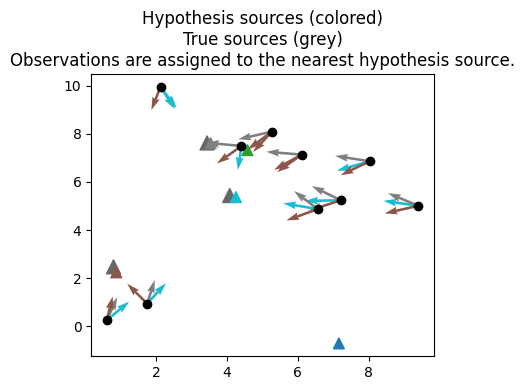

In [13]:
figure, axis = plt.subplots(1, 1, figsize=(4, 4))
visualize_observations(axis, bodies=true_bodies, cmap_name="grey", bodysize=100)
visualize_observations(axis, bodies=param_mu, bodysize=60)
visualize_assignments(
    axis,
    e_step(K, param_mu, param_psi, kappa, **obs_kwargs),
    **obs_kwargs,
)

axis.set_title(
    "Hypothesis sources (colored)\n"
    "True sources (grey)\n"
    "Observations are assigned to the nearest hypothesis source."
)
figure.tight_layout()

In [14]:
# How closely does param_psi match the proportions of true labels?

np.set_printoptions(precision=2)
print("Ground truth")
for i, body in enumerate(true_bodies):
    proportion = np.sum(true_labels == i) / len(true_labels)
    print(f"\tFor body {body}, expected proportion {proportion:.2f}")

print("Hypotheses")
for mu, psi in zip(param_mu, param_psi):
    print(f"\tFor mean {mu}, expected proportion {psi:.2f}")

Ground truth
	For body [4.08 5.44], expected proportion 0.33
	For body [3.44 7.62], expected proportion 0.33
	For body [0.8  2.47], expected proportion 0.33
Hypotheses
	For mean [ 7.16 -0.71], expected proportion 0.00
	For mean [4.58 7.33], expected proportion 0.00
	For mean [0.88 2.24], expected proportion 0.38
	For mean [3.54 7.61], expected proportion 0.32
	For mean [4.26 5.37], expected proportion 0.30


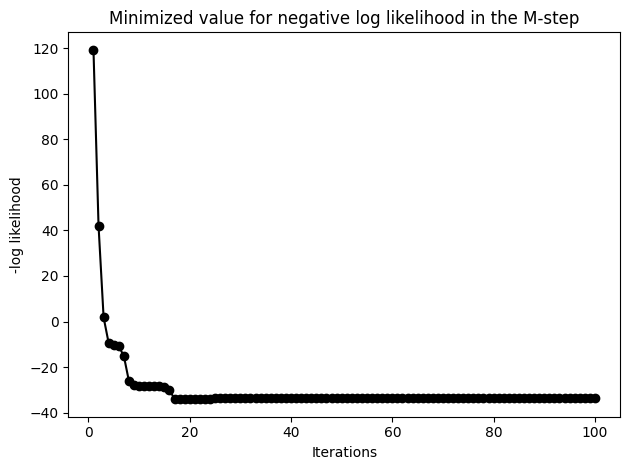

In [15]:
# Does the cost go down over time?

x = range(len(history))
y = [snapshot[2] for snapshot in history]
plt.plot(x, y, "ko-")

plt.xlabel("Iterations")
plt.ylabel("-log likelihood")
plt.title("Minimized value for negative log likelihood in the M-step")
plt.tight_layout()

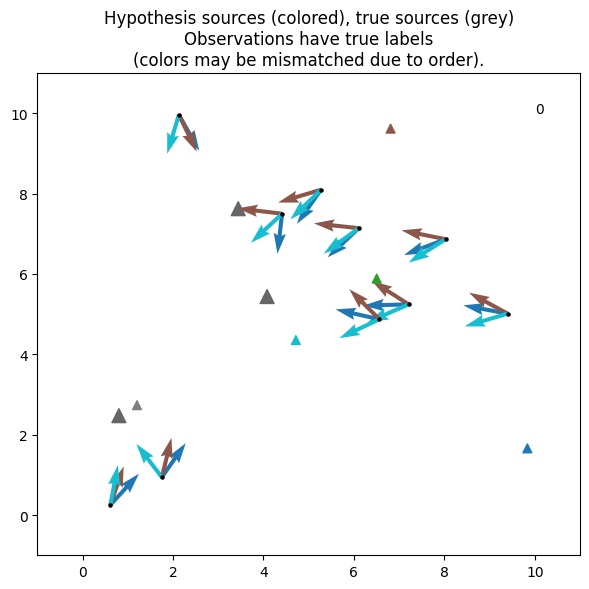

In [16]:
figure, axis = plt.subplots(1, 1, figsize=(6, 6))

def update(frame_idx):
    axis.clear()
    axis.set_xlim(-1, 11)
    axis.set_ylim(-1, 11)
    # Reapply after clearing
    visualize_observations(axis, bodies=true_bodies, cmap_name="grey", bodysize=100)
    visualize_observations(axis, labels=true_labels, **obs_kwargs)
    # Plot the current history frame
    mu, _, _ = history[frame_idx]
    visualize_observations(axis, bodies=mu)
    plt.text(10, 10, str(frame_idx))

    axis.set_title(
        "Hypothesis sources (colored), true sources (grey)\n"
        "Observations have true labels\n"
        "(colors may be mismatched due to order)."
    )
    figure.tight_layout()

view = animation.FuncAnimation(
    figure,
    update,
    frames=iterations,
    interval=200,  # ms between frames
)

HTML(view.to_jshtml())